In [87]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import scipy as sp

from io import BytesIO
from PIL import Image
from tqdm import tqdm

from keras.applications import VGG16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import (
    load_img, 
    img_to_array, 
    array_to_img, 
    ImageDataGenerator
)
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [19]:
cracks_pd = pd.read_json('./cracks.json', lines=True)
cracks_pd['label'] = cracks_pd.annotation.apply(
    lambda annotation: annotation['labels'][0] if len(annotation['labels']) > 0 else 'Crack'
)
cracks_pd.head()

,content,annotation,extras,metadata,label
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['no Crack'], 'note': ''}",NaN,"{'first_done_at': 1528371420000, 'last_updated...",no Crack
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['Crack'], 'note': ''}",NaN,"{'first_done_at': 1528373761000, 'last_updated...",Crack
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['Crack'], 'note': ''}",NaN,"{'first_done_at': 1528371146000, 'last_updated...",Crack
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['Crack'], 'note': ''}",NaN,"{'first_done_at': 1528371734000, 'last_updated...",Crack
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['no Crack'], 'note': ''}",NaN,"{'first_done_at': 1528372265000, 'last_updated...",no Crack


In [39]:
images = []
for link in tqdm(cracks_pd.content):
    
    response = requests.get(link)
    image = Image.open(BytesIO(response.content))
    image = image.resize((224, 224))
    image_array = img_to_array(image)
    images.append(image_array.astype(np.float32))

100%|██████████| 1428/1428 [10:37<00:00,  2.56it/s]


array([[[[ 87.,  83.,  82.],
         [ 97.,  93.,  92.],
         [ 98.,  94.,  93.],
         ...,
         [196., 198., 197.],
         [195., 197., 196.],
         [195., 197., 196.]],

        [[ 86.,  82.,  81.],
         [ 92.,  91.,  89.],
         [ 92.,  91.,  89.],
         ...,
         [197., 199., 198.],
         [198., 200., 199.],
         [197., 199., 198.]],

        [[ 84.,  83.,  81.],
         [ 91.,  90.,  88.],
         [ 90.,  89.,  87.],
         ...,
         [198., 200., 199.],
         [198., 200., 199.],
         [197., 199., 198.]],

        ...,

        [[ 94.,  82.,  66.],
         [ 80.,  71.,  56.],
         [ 84.,  76.,  65.],
         ...,
         [114., 115., 107.],
         [108., 109., 101.],
         [123., 124., 116.]],

        [[ 90.,  78.,  62.],
         [ 86.,  77.,  62.],
         [ 85.,  75.,  63.],
         ...,
         [115., 116., 108.],
         [105., 106.,  98.],
         [118., 119., 111.]],

        [[ 90.,  81.,  64.],
       

In [41]:
images_arr = np.array(images)
print(images_arr.shape)

(1428, 224, 224, 3)


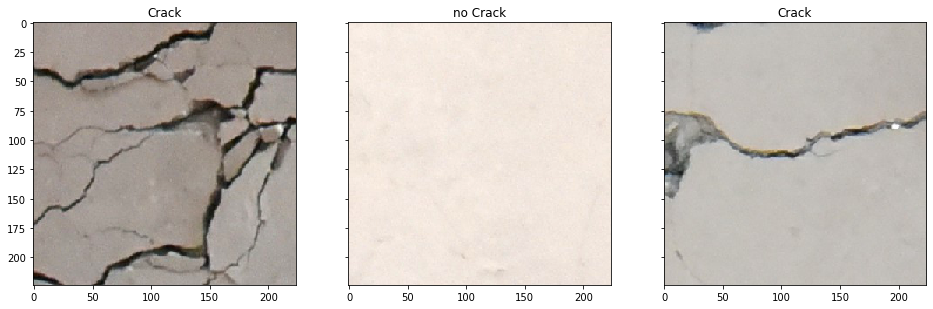

In [51]:
# Plot random images

rand_indices = np.random.randint(0, images_arr.shape[0], 3)
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16, 10))
for ax, img, label in zip(axes, images_arr[rand_indices], cracks_pd.label[rand_indices]):
    ax.imshow(array_to_img(img))
    ax.set_title(label)

In [52]:
vgg_net = VGG16(weights='imagenet', include_top=False, input_shape = (224, 224, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [53]:
for layer in vgg_net.layers[:-8]:
    layer.trainable = False
for layer in vgg_net.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x63d62b828> False
<keras.layers.convolutional.Conv2D object at 0x63d63fba8> False
<keras.layers.convolutional.Conv2D object at 0x63d63ada0> False
<keras.layers.pooling.MaxPooling2D object at 0x63d7162e8> False
<keras.layers.convolutional.Conv2D object at 0x63d724710> False
<keras.layers.convolutional.Conv2D object at 0x63d5cad30> False
<keras.layers.pooling.MaxPooling2D object at 0x63d65ef98> False
<keras.layers.convolutional.Conv2D object at 0x63d5fd710> False
<keras.layers.convolutional.Conv2D object at 0x63d5ef198> False
<keras.layers.convolutional.Conv2D object at 0x63d643908> False
<keras.layers.pooling.MaxPooling2D object at 0x63d5dcf28> False
<keras.layers.convolutional.Conv2D object at 0x63d5e1828> True
<keras.layers.convolutional.Conv2D object at 0x63d5e5208> True
<keras.layers.convolutional.Conv2D object at 0x63d5c60f0> True
<keras.layers.pooling.MaxPooling2D object at 0x63d5bd2e8> True
<keras.layers.convolutional.Conv2D object 

In [57]:
y = to_categorical(cracks_pd.label=='Crack')

In [58]:
x_train, x_test, y_train, y_test = train_test_split(images_arr, y, test_size=0.2)

In [65]:
x = vgg_net.output
x = GlobalAveragePooling2D()(x)
x = Dense(2, activation='softmax')(x)

model = Model(vgg_net.input, x)
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=1e-4),
    metrics=['accuracy']
)

In [66]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [67]:
train_data_gen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip=True,
    width_shift_range=0.3,
    height_shift_range=0.3,
    fill_mode='nearest',
    rotation_range=30
)

In [68]:
train_data_gen.fit(x_train)

In [70]:
model.fit_generator(
    train_data_gen.flow(x_train, y_train, batch_size=16),
    epochs=3,
    steps_per_epoch=int(len(x_train)/16)
)

Epoch 1/3
71/71 [==============================] - 868s 12s/step - loss: 0.3333 - acc: 0.8750
Epoch 2/3
71/71 [==============================] - 833s 12s/step - loss: 0.2754 - acc: 0.8967
Epoch 3/3
71/71 [==============================] - 846s 12s/step - loss: 0.2743 - acc: 0.8973


In [75]:
prediction = model.predict(x_test / 255)

In [79]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(prediction, axis=1)))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       162
           1       0.93      0.90      0.92       124

    accuracy                           0.93       286
   macro avg       0.93      0.93      0.93       286
weighted avg       0.93      0.93      0.93       286



Text(0.5, 0, 'Predicted label')

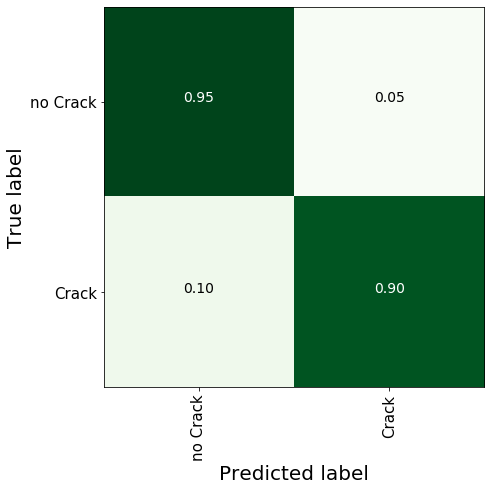

In [89]:
cfx_mtx = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(prediction, axis=1))
plt.figure(figsize=(7,7))
cfx_mtx = cfx_mtx.astype(np.float32) / cfx_mtx.sum(axis=1)[:, np.newaxis]
plt.imshow(cfx_mtx, interpolation='nearest', cmap=plt.cm.Greens)
classes = cracks_pd.label.unique()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
plt.yticks(tick_marks, classes, fontsize=15)
fmt = '.2f'
thresh = cfx_mtx.max() / 2.
for i, j in itertools.product(range(cfx_mtx.shape[0]), range(cfx_mtx.shape[1])):
    plt.text(j, i, format(cfx_mtx[i, j], fmt),
             horizontalalignment="center",
             color="white" if cfx_mtx[i, j] > thresh else "black", fontsize = 14)

plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)

In [90]:
def plot_activation(img):
    pred = model.predict(img[np.newaxis,:,:,:])
    pred_class = np.argmax(pred)
  
    weights = model.layers[-1].get_weights()[0]
    class_weights = weights[:, pred_class]
  
    intermediate = Model(model.input, model.get_layer("block5_conv3").output)
    conv_output = intermediate.predict(img[np.newaxis,:,:,:])
    conv_output = np.squeeze(conv_output)
  
    h = int(img.shape[0]/conv_output.shape[0])
    w = int(img.shape[1]/conv_output.shape[1])
  
    activation_maps = sp.ndimage.zoom(conv_output, (h, w, 1), order=1)
    out = np.dot(activation_maps.reshape((img.shape[0]*img.shape[1], 512)), class_weights).reshape(img.shape[0],img.shape[1])
  
    plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
    plt.imshow(out, cmap='jet', alpha=0.35)
    plt.title('Crack' if pred_class == 1 else 'No Crack')

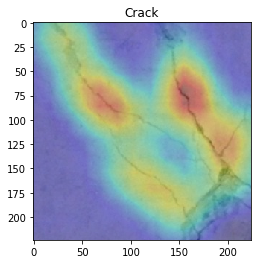

In [92]:
plot_activation(x_test[200]/255)

In [ ]:

plot_activation(X_test[100]/255)